# Deep Convolutional - Image Colorization
Image colorization of grayscale to rgb directly. This is order to see the limitation of using RGB as the output when computing the loss.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image

## Import all Modules and Configure GPU

In [18]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import pathlib
import os.path
import math
import PIL
import PIL.Image
import imageio.v2 as imageio
import glob


## Configure GPU

In [3]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2022-06-15 06:48:41.271193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 06:48:41.294201: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 06:48:41.294383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
tf.__version__


'2.9.1'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [5]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='grayscale',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    image_count = len(list(data_test_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_test_dir, image_count))

    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = test_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds)), AUTOTUNE)


In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = (128, 128)
EPOCHS = 128

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-colorize: Found 92219 files
Found 92219 files belonging to 1 classes.


2022-06-15 06:48:56.480901: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 06:48:56.481729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 06:48:56.482040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 06:48:56.482217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

data-colorize: Found 92219 files
Found 92219 files belonging to 1 classes.
Number of batches 2882 of 32 elements


2022-06-15 06:48:59.246499: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


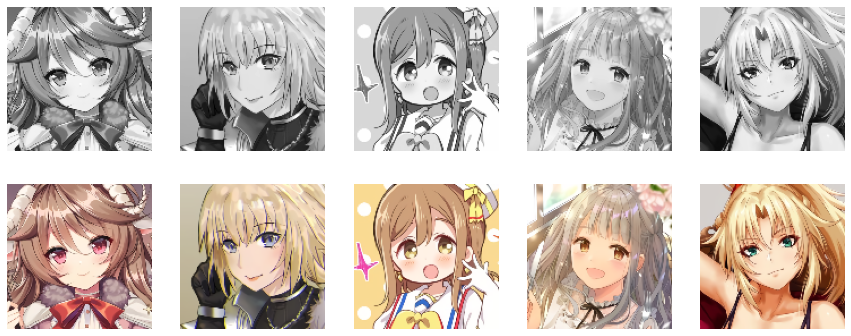

In [7]:

num_examples_to_generate = 5

plt.figure(figsize=(15, 6))
for images in train_images.take(1):
    for i in range(0, num_examples_to_generate):
        ax = plt.subplot(2, num_examples_to_generate, i + 1)
        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow(trainImage[i, :, :, :].numpy().astype(dtype='float32'), cmap='gray')
        plt.axis("off")
        ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((expectedImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
        plt.axis("off")
plt.show()


## Creating The Model
The model is created, similar to a audo encoding. However, in this model, there is node latent space. Instead it uses more of pure convolution network.

In [8]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    num_layers = hp.Int('number_of_layers', min_value=2, max_value=4, step=1)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))
        
        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', strides=2, kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        #model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=7, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), padding='same', kernel_initializer=kernel_init))
        model.add(layers.ReLU(dtype='float32'))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(3, (3, 3), padding='same', kernel_initializer=kernel_init))
    model.add(layers.Activation(activation='tanh', dtype='float32'))

    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss='mse',
                  metrics=['accuracy'])

    return model


## Hyperparameter

In [9]:

image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                    objective='accuracy',
                    max_epochs=16,
                    factor=5,
                    directory='cache',
                    project_name=str.format('Colorizing - GrayScale Input - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(train_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


Trial 13 Complete [00h 19m 59s]
accuracy: 0.7369300723075867

Best accuracy So Far: 0.7415814995765686
Total elapsed time: 04h 13m 54s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 128, 32)      320       
                                                                 
 re_lu_15 (ReLU)             (None, 128, 128, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 re_lu_16 (ReLU)             (None, 64, 64, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 re_lu_17 (Re

In [10]:
def showResult(model, batchImage):
    maxNumImages = 5
    pred = (model.predict(batchImage) + 1.0) / 2.0
    nrElements = min(len(pred), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, maxNumImages))
    for image in batchImage:
        for i in range(nrElements):
            _, expectedImage = image

            ax = plt.subplot(2, maxNumImages, i + 1)
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow((expectedImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
            plt.axis("off")
            ax = plt.subplot(2, maxNumImages, maxNumImages + 1 + i)
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow(asarray(pred[i, :, :, :]).astype(dtype='float32'))
            plt.axis("off")
    plt.close()
    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("animeColor{0}.png".format(epoch))


In [11]:


model_history = {}

checkpoint_path = "checkpoints/training_anime_coloring_grayscale/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_images,
                          epochs=EPOCHS,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/128
2882/2882 [==============================] - 72s 25ms/step - loss: 0.1921 - accuracy: 0.7386
Epoch 2/128
2882/2882 [==============================] - 71s 25ms/step - loss: 0.1184 - accuracy: 0.7379
Epoch 3/128
2882/2882 [==============================] - 70s 24ms/step - loss: 0.1115 - accuracy: 0.7384
Epoch 4/128
2882/2882 [==============================] - 72s 25ms/step - loss: 0.1076 - accuracy: 0.7386
Epoch 5/128
2882/2882 [==============================] - 73s 25ms/step - loss: 0.1043 - accuracy: 0.7386
Epoch 6/128
2882/2882 [==============================] - 74s 26ms/step - loss: 0.1018 - accuracy: 0.7384
Epoch 7/128
2882/2882 [==============================] - 77s 27ms/step - loss: 0.0997 - accuracy: 0.7379
Epoch 8/128
2882/2882 [==============================] - 75s 26ms/step - loss: 0.0981 - accuracy: 0.7370
Epoch 9/128
2882/2882 [==============================] - 73s 25ms/step - loss: 0.0968 - accuracy: 0.7362
Epoch 10/128
2882/2882 [==============================]

In [12]:
model.save("dc-anime-colorization.h5")


# Result

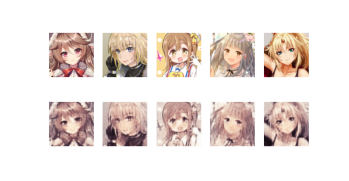

In [15]:
plt.imshow(PIL.Image.open("animeColor{0}.png".format(EPOCHS - 1)))
plt.axis("off")
plt.show()

In [19]:
anim_file = 'anime-colorizing.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('animeColor*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Image(url=anim_file)

In [20]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


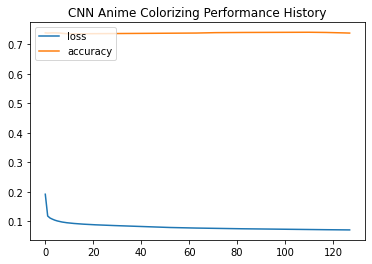

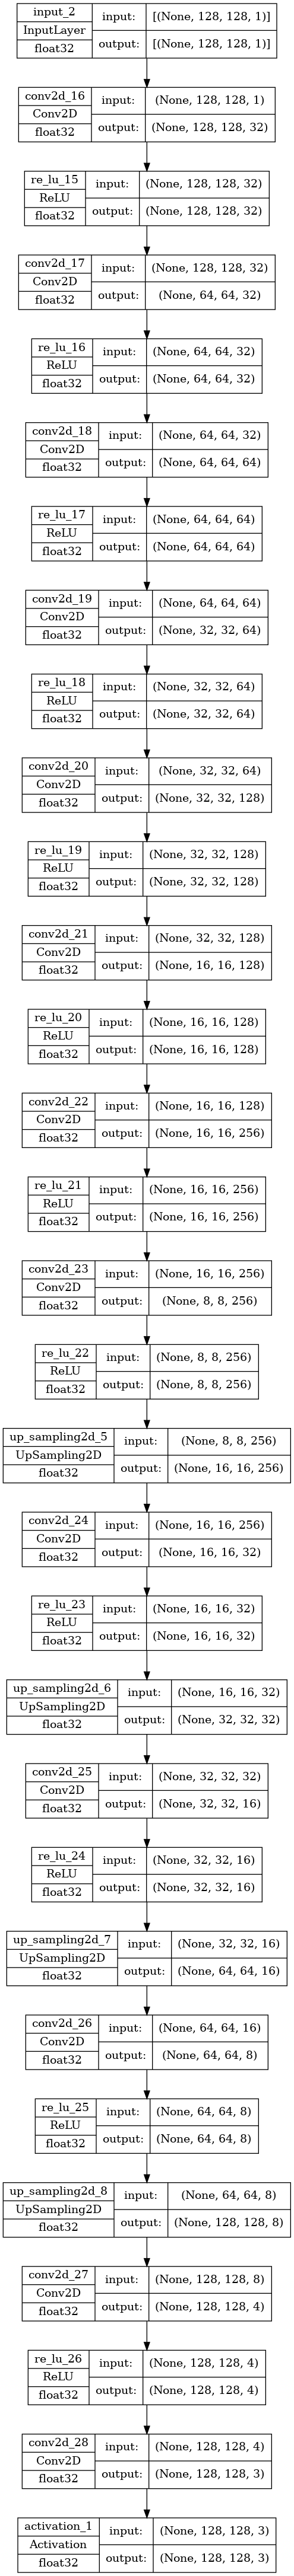

<Figure size 432x288 with 0 Axes>

In [21]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('cnn_{0}_model.png', "Anime Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
